Evan Mikesell 

May 2022

# Predicting User Ratings For Movies on IMDb.com.

For this project I will be using different algorithms to predict the user rating for movies on IMDb.com, and assessing the effectiveness of each algorithm. 

User ratings are scored on a scale from 1-10, and any registed user can rate a movie.

This will be done using data from the IMDb dataset as well as data pulled from the TMDb dataset. 

I will be predicting user ratings based on various different features such as genre, runtime, release date, etc.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

# Retrieving the Data

IMDB Data: 
https://www.imdb.com/interfaces/

    This contains information on each movies title, rating, genre, runtime, release year, and more.

TMDB Data:
https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=links.csv

    This contains information on the movies budget, revenue, language, production companies, and production country.


CPI Data:
https://www.bls.gov/cpi/data.htm

    This contains the CPI (Consumer Price Index) per year, which we can use to adjust prices for inflation.

In [9]:
#change this path
file_path =  r"C:\Users\mikes\Desktop\CS649 Project\\" 

#IMDb files
title_basics = pd.read_csv(file_path + r'title_basics.tsv', sep='\t', low_memory=False)
title_crew = pd.read_csv(file_path + r'title_crew.tsv', sep='\t')
title_ratings = pd.read_csv(file_path + r'title_ratings.tsv', sep='\t')
name_basics = pd.read_csv(file_path + r'name_basics.tsv', sep='\t')

#TMDb file
movies_metadata = pd.read_csv(file_path + r"movies_metadata.csv", sep=',', low_memory=False)
#CPI file
cpi_dataframe = pd.read_excel(file_path + r"\CPI_per_year.xlsx")

# Cleaning and Preparing the Data



In [10]:
#getting only movies that have a runtime, genres, and a release year
movies_title_basics = title_basics[title_basics['titleType']=='movie'].reset_index()
movies_title_basics = movies_title_basics[movies_title_basics.runtimeMinutes != r'\N']
movies_title_basics = movies_title_basics[movies_title_basics.genres != r'\N']
movies_title_basics = movies_title_basics[movies_title_basics.startYear != r'\N']

#from our TMDB file, we only need the budget, revenue, imdb_id, original_language, production_companies, and production_countires columns
tmdb_data = movies_metadata.drop(movies_metadata.columns.difference(['budget', 'revenue', 'imdb_id', 'original_language', 'production_companies', 'production_countries']), 1)

To start, we will merge the data from all of our different text files into one dataframe. 

Each movie has an ID, which we will use to merge all of our information together.

In [11]:
#merging all of our dataframes together

#create a dataframe containing the movie ID and the name of the director
movie_directors = pd.merge(title_crew, name_basics[['nconst','primaryName']], left_on='directors', right_on='nconst').drop(columns = ['nconst', 'writers'])

#merge our movie ratings, directors, and basic movie information into one dataframe
movie_data = pd.merge(movies_title_basics, title_ratings, left_on='tconst', right_on='tconst')
movie_data = pd.merge(movie_data, movie_directors, left_on='tconst', right_on='tconst')

#now merging the TMDb data
movie_data = pd.merge(movie_data, tmdb_data, left_on='tconst', right_on='imdb_id')
movie_data = movie_data[pd.to_numeric(movie_data['startYear'], errors='coerce').notnull()]
movie_data['startYear'] = movie_data['startYear'].astype(int)

#dropping all unnecessary columns
movie_data.drop(columns=['index', 'titleType', 'originalTitle', 'isAdult', 'endYear', 'directors', 'tconst'], inplace=True)
movie_data.rename(columns={"primaryName": "director"}, inplace=True)

#creating a minimum amount of votes required for each movie
minimum_votes = 3000
movie_data = movie_data[movie_data['numVotes'] > minimum_votes]

#casting the budget and revenue columns to integers 
movie_data = movie_data[pd.to_numeric(movie_data['budget'], errors='coerce').notnull()]
movie_data = movie_data[pd.to_numeric(movie_data['revenue'], errors='coerce').notnull()]
movie_data['budget'] = movie_data['budget'].astype(int)
movie_data['revenue'] = movie_data['revenue'].astype(int)

#only using movies that have budgets and revenues greater than zero
movie_data = movie_data[movie_data['budget'] > 0]
movie_data = movie_data[movie_data['revenue'] > 0]

# Adjusting for Inflation

Now that we have merged all of our data into one dataframe, we will need to adjust the budget and revenue for inflation.

We use the CPI (Consumer Price Index) per year to calculate the inflation.

The equation for adjusting a price from a past year to the current year is:

adjusted_price = (current_cpi / past_cpi) * price

or 

adjusted_price = inflation_multiplier * price


We will create an inflation multiplier column in our movie_data dataframe, based on the movies release year. Then we will multiply the budget and revenue with this inflation multiplier to get the budget and revenues adjusted for inflation.

In [12]:
#CPI file
cpi_per_year = cpi_dataframe.copy()

current_year = date.today().year
current_cpi = cpi_per_year.loc[cpi_per_year['Year']==current_year, 'Annual'].values[0]

cpi_per_year.rename(columns={'Annual': 'inflation_multiplier'}, inplace=True)
cpi_per_year['inflation_multiplier'] = current_cpi / cpi_per_year['inflation_multiplier']

#equation for adjusting inflation: (current_cpi / past_cpi) * price
movie_data = pd.merge(movie_data, cpi_per_year, left_on='startYear', right_on='Year')

#adjusting the values for inflation
movie_data['revenue'] =  movie_data['revenue'] * movie_data['inflation_multiplier']
movie_data['budget'] =  movie_data['budget'] * movie_data['inflation_multiplier']

Here is our full movie_data dataframe containing all of the information we will be using to predict the IMDb ratings.

In [13]:
display(movie_data)

,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,director,budget,imdb_id,original_language,production_companies,production_countries,revenue,Year,inflation_multiplier
0,The Birth of a Nation,1915,195,"Drama,History,War",6.2,24346,D.W. Griffith,2.846574e+06,tt0004972,en,"[{'name': 'Epoch Film Co.', 'id': 351}]","[{'iso_3166_1': 'US', 'name': 'United States o...",3.131232e+08,1915,28.465743
1,The Kid,1921,68,"Comedy,Drama,Family",8.3,123871,Charles Chaplin,4.015419e+06,tt0012349,en,"[{'name': 'Charles Chaplin Productions', 'id':...","[{'iso_3166_1': 'US', 'name': 'United States o...",4.015419e+07,1921,16.061676
2,Foolish Wives,1922,117,"Drama,Thriller",7.0,3538,Erich von Stroheim,1.882467e+07,tt0013140,en,[{'name': 'Universal Film Manufacturing Compan...,"[{'iso_3166_1': 'US', 'name': 'United States o...",6.848756e+06,1922,17.113333
3,The Thief of Bagdad,1924,155,"Adventure,Family,Fantasy",7.7,6111,Raoul Walsh,1.909386e+07,tt0015400,en,"[{'name': 'Douglas Fairbanks Pictures', 'id': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2.040909e+07,1924,16.813099
4,The Gold Rush,1925,95,"Adventure,Comedy,Drama",8.2,109189,Charles Chaplin,1.516378e+07,tt0015864,en,"[{'name': 'Charles Chaplin Productions', 'id':...","[{'iso_3166_1': 'US', 'name': 'United States o...",4.107200e+07,1925,16.428800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4666,Black Snow,2017,90,"Crime,Drama,Mystery",6.2,5736,Martín Hodara,4.691645e+06,tt5614612,es,"[{'name': 'Telefe', 'id': 8046}, {'name': 'A C...","[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_...",1.688992e+06,2017,1.172911
4667,Diary of a Wimpy Kid: The Long Haul,2017,91,"Adventure,Comedy,Family",4.3,8815,David Bowers,2.580405e+07,tt6003368,en,"[{'name': 'Twentieth Century Fox', 'id': 7392}]","[{'iso_3166_1': 'US', 'name': 'United States o...",4.705737e+07,2017,1.172911
4668,A Ghost Story,2017,92,"Drama,Fantasy,Romance",6.8,69791,David Lowery,1.172911e+05,tt6265828,en,"[{'name': 'Sailor Bear', 'id': 14634}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1.827895e+07,2017,1.172911
4669,Phoenix Forgotten,2017,87,"Horror,Mystery,Sci-Fi",5.3,6199,Justin Barber,3.284151e+06,tt6574272,en,"[{'name': 'Scott Free Productions', 'id': 1645...","[{'iso_3166_1': 'US', 'name': 'United States o...",4.222480e+06,2017,1.172911


# Creating Dummy Variables for Categorical Variables

To use categorical variables like genre, directors, etc. we need to create dummy variables. These dummy variables will be their own columns with a value of 0 or 1 for each category.


For example, a movie with the genre Comedy will have a 1 in the 'Comedy' column, but it may have a 0 in the 'Horror' column.

# Genres

Each movie in the data set can have multiple genres. For example, there can be a movie with the genres adventure, comedy, and drama.

Rather than evaluating combinations of genres, I decided to just check for each genre individually being present in the list of genres for the movie itself. 

We create a dataframe of dummies and concatenate it onto our movie_data_dummies dataframe.



In [14]:
#creating a dataframe with dummy variables for directors, genres, production studios, production countries.
movie_data_dummies = movie_data.copy()
movie_data_dummies['genres'] = movie_data.genres.apply(lambda x: x.split(','))

#https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies 
genres_dummies = pd.get_dummies(movie_data_dummies['genres'].explode()).sum(level=0)

movie_data_dummies = pd.concat([movie_data_dummies, genres_dummies], axis=1)
unique_genres = list(genres_dummies.columns)

Here is what our dummy variables for genres looks like:

In [15]:
pd.set_option('max_columns', 30)
display(genres_dummies)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4666,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4667,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4668,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4669,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


# Languages

Getting the dummies for languages is much simpler than genres, as movies only have one original language. The pandas get_dummies function creates our list of dummies without any trouble.

In [16]:
unique_languages = movie_data_dummies['original_language'].value_counts()
unique_languages = unique_languages.index.tolist()   
languages_dummies = pd.get_dummies(movie_data_dummies['original_language'])
movie_data_dummies = pd.concat([movie_data_dummies, languages_dummies], axis=1)

# Directors

When it comes to directors, I made the choice to only select a small amount of them. There are many directors who only worked on one or a small amount of movies, so after testing out some different values, I decided to just use the 15 directors with the highest amount of movies in our dataset.

In [17]:
#we'll only use some of the directors rather than using every single one
directors_count = 15
top_directors = movie_data_dummies['director'].value_counts()[0:directors_count]
directors_dummies = pd.get_dummies(movie_data_dummies['director'])
top_directors = top_directors.index.tolist()
directors_dummies.drop(directors_dummies.columns.difference(top_directors), 1, inplace=True)
movie_data_dummies = pd.concat([movie_data_dummies, directors_dummies], axis=1)

# Production Companies and Production Countries

Production companies and production countries were a bit trickier to extract from our data. The values were stored in a string that looked something like this: 

In [18]:
movie_data_dummies['production_companies'][445]

"[{'name': 'Radiant Film GmbH', 'id': 209}, {'name': 'Süddeutscher Rundfunk', 'id': 210}, {'name': 'Columbia Pictures Corporation', 'id': 441}, {'name': 'Bavaria Film', 'id': 1704}, {'name': 'Westdeutscher Rundfunk (WDR)', 'id': 7025}, {'name': 'Twin Bros. Productions', 'id': 11344}]"

In [19]:
movie_data_dummies['production_countries'][442]

"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]"

There can be many different companies involved in the movie as well as many different countries, so we have a situation similar to the genres. However, the way the data was stored was a little tricky to work with compared to the genres, which simply stored the genres in a string seperated by commas. Here, I needed to use a regular expression to get the names of the countries and production companies. 

Production companies and countries also had a similar issue to directors, where many companies or countries would only have one or a very small number of movies associated with them, so we will only be using the most common countries and companies.

In [20]:
#some functions used to get our dummy variables for countries and companies.

def unique_values(column):
    """Creating a dictionary for each unique value from our categorical variables along with their frequency.

    Args: 
        column: 
            A column from the dataframe for a categorical variable (production company, country)

    Returns:
        item_count: 
            The dictionary containing the count for each category.
    """
    item_count = dict()
    for item_list in column:
        for item in item_list:
            if not item in [*item_count]:
                item_count[item] = 0
        item_count[item] += 1
    return item_count
  
def get_dummies_from_string(dataframe, column_name, regex_string, minimum_movies):
    """Gets dummy variables from a column where the values need to be extracted from a string.

    Args: 
        dataframe: 
            Dataframe with our movie data.
        column_name:
            Name of the column for the categorical variable.
        regex_string:
            Regex string which we apply to the column to get our categories.
        minimum_movies:
            Minimum number of movies that are associated with the category for it to be included.
            
    Returns:
        dummies: 
            Dummy variables for the given column.
        filtered_items:
            A list of the categories for the dummy variables.
    """
    dataframe[column_name] = dataframe[column_name].str.findall(regex_string)

    column = dataframe[column_name]
    item_count = unique_values(column)

    #set a minimum number of movies created in this company/country/etc. to be included
    for key, value in dict(item_count).items():
        if value < minimum_movies:
            del item_count[key]
    filtered_items = [*item_count]

    dummies = pd.get_dummies(dataframe[column_name].explode()).sum(level=0)
    dummies.drop(dummies.columns.difference(filtered_items), 1, inplace=True)
    return dummies, filtered_items

## Production Companies

In [21]:
#minimum movies created by company to be included as a category
company_minimum_movies = 15
regex = '(?<=\'name\': ).(.*?)\''
companies_dummies, filtered_companies = get_dummies_from_string(dataframe=movie_data_dummies, column_name='production_companies', 
                                                                regex_string=regex, minimum_movies=company_minimum_movies)

movie_data_dummies = pd.concat([movie_data_dummies, companies_dummies], axis=1)

## Production Countries

In [22]:
#minimum movies created in the country to be included as a category
country_minimum_movies = 50
countries_dummies, filtered_countries = get_dummies_from_string(dataframe=movie_data_dummies, column_name='production_countries', 
                                                                regex_string=regex, minimum_movies=country_minimum_movies)

movie_data_dummies = pd.concat([movie_data_dummies, countries_dummies], axis=1)

# Predicting Ratings

To predict the IMDb ratings, we will be using linear regression, random forest regression, and elastic net regression.

We will compare their R squared scores, mean squared errors, and their 'accuracy', which is just the percentage of predictions that are within 1 point of the actual rating.

In [23]:
def adjusted_r2_score(actual_ratings, predicted_ratings, feature_count):
    """Calculates the adjusted r squared score.

    Args: 
        actual_ratings: 
            The actual ratings of the movies, our y_test.
        predicted_ratings:
            The ratings that our model has predicted.
        feature_count:
            The number of independent variables.
            
    Returns:
        adjusted_r2:
            The adjusted r squared value.
    """
    r2 = r2_score(actual_ratings, predicted_ratings)
    n = len(predicted_ratings)
    p = feature_count
    adjusted_r2 = 1 - (((1 - r2) * (n - 1)) / (n - p - 1))         
    return adjusted_r2

def prediction_percentage(correct_range, predicted_ratings, actual_ratings):
    """Calculates the percentage of predictions within our given range.

    Args: 
        correct_range: 
            The window in which a prediction is 'correct.' 
        predicted_ratings:
            The ratings that our model has predicted.
        actual_ratings:
            The actual ratings of the movies.
            
    Returns:
        percentage:
            The percentage of 'correct' predictions.
    """
    correct_predictions = 0 
    actual_ratings = list(actual_ratings)
    for i in range(0, len(predicted_ratings)):
        predicted = predicted_ratings[i]
        real = actual_ratings[i]
        if abs(predicted - real) < correct_range:
            correct_predictions += 1  
    percentage = (correct_predictions / len(predicted_ratings))
    percentage = percentage * 100
    percentage = round(percentage, 2)
    return percentage

# Creating the Training and Test Data

In [133]:
ratings = movie_data_dummies['averageRating']
columns = ['numVotes', 'runtimeMinutes', 'startYear', 'budget', 'revenue']

#adding our categorical variables
columns = columns + unique_genres + unique_languages + top_directors + filtered_companies + filtered_countries
feature_count = len(columns)
X = movie_data_dummies[columns]
X_train, X_test, y_train, y_test = train_test_split(X, ratings, train_size=0.8, test_size=0.2)

# Linear Regression

Linear Regression R2:  0.46810454196172313
Percentage of predictions within 0.5 of the actual rating: 58.82%
Mean Sqaured Error is: 0.46057626082544834


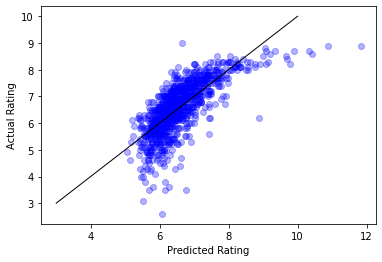

<Figure size 432x288 with 0 Axes>

In [134]:
model = LinearRegression()
model.fit(X_train,y_train)
lr_pred = model.predict(X_test)

lr_r2 = adjusted_r2_score(y_test, lr_pred, feature_count)
print("Linear Regression R2: ", lr_r2)

#how close a prediction has to be to the actual rating to be "correct"
prediction_range = 0.5
lr_prediction_rate = prediction_percentage(correct_range=prediction_range, predicted_ratings=lr_pred, actual_ratings=y_test)
print("Percentage of predictions within", prediction_range, "of the actual rating:", str(lr_prediction_rate) + "%")
print("Mean Sqaured Error is:", mean_squared_error(y_test, lr_pred))

#plotting the predicted vs actual ratings
plt.scatter(lr_pred, y_test, c='blue', alpha=0.3)
plt.plot([3, 10], [3, 10], lw=1, c='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()
plt.clf()

# Random Forest Regression

Random Forest Regression R2:  0.6110554917735962
Percentage of predictions within 0.5 of the actual rating: 69.3%
Mean Sqaured Error is: 0.3367928877005347


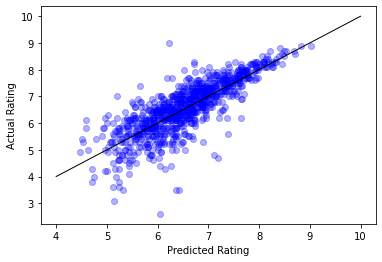

<Figure size 432x288 with 0 Axes>

In [135]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
rf_pred = model.predict(X_test)

rf_r2 = adjusted_r2_score(y_test, rf_pred, feature_count)
print("Random Forest Regression R2: ", rf_r2)

#how close a prediction has to be to the actual rating to be "correct"
rf_prediction_rate = prediction_percentage(correct_range=prediction_range, predicted_ratings=rf_pred, actual_ratings=y_test)
print("Percentage of predictions within", prediction_range, "of the actual rating:", str(rf_prediction_rate) + "%")
print("Mean Sqaured Error is:", mean_squared_error(y_test, rf_pred))

plt.scatter(rf_pred, y_test, c='blue', alpha=0.3)
plt.plot([4, 10], [4, 10], lw=1, c='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()
plt.clf()

# Elastic Net

Elastic Net R2:  0.33323193307124443
Percentage of predictions within 0.5 of the actual rating: 52.19%
Mean Sqaured Error is: 0.5773644772912477


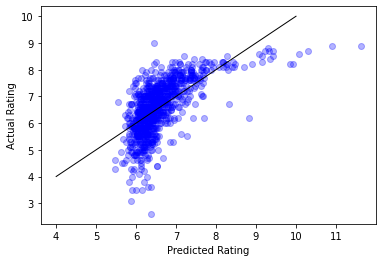

<Figure size 432x288 with 0 Axes>

In [136]:
model = ElasticNet()
model.fit(X_train, y_train)
en_pred = model.predict(X_test)

en_r2 = adjusted_r2_score(y_test, en_pred, feature_count)
print("Elastic Net R2: ", en_r2)

#how close a prediction has to be to the actual rating to be "correct"
en_prediction_rate = prediction_percentage(correct_range=prediction_range, predicted_ratings=en_pred, actual_ratings=y_test)
print("Percentage of predictions within", prediction_range, "of the actual rating:", str(en_prediction_rate) + "%")
print("Mean Sqaured Error is:", mean_squared_error(y_test, en_pred))

plt.scatter(en_pred, y_test, c='blue', alpha=0.3)
plt.plot([4, 10], [4, 10], lw=1, c='black')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()
plt.clf()

# Analysis

We will look at the r squared score, prediction accuracy, and mean sqaured error to evaluate the effectiveness of each of these models. The values shown by the algorithms may be slightly different the values I talk about in this section due to the randomness involved in splitting the training and testing data. However, the differences should be pretty small.

The r squared score is the percentage of variability in the ratings which can be explained by our model. An r squared of 0.5 means that 50% of the variability is explained by our model, a score of 0.9 means that 90% is explained by our model. A higher score is better. What counts as a 'good' r squared value can depend on the context, consistently predicting something like movie ratings can be hard because how 'good' a movie is can be very subjective. The highest r sqaured value out of the three models here was 0.61, from the random forest regression, which means 39% of the variability can be explained by the model.

The prediction accuracy tells us how many predictions were within 0.5 points of the actual rating. Setting the window for correct predictions to 0.5 felt correct to me. The highest prediction percentage came from random forest regression, at 69.11%.

The mean sqaured error is similar to the prediction accuracy. It tells us the average squared difference between the predicted and real rating values. A smaller mean squared error is better. Our smallest mean squared error here was random forest regression with a value of 0.33, which means on average the predictions could be wrong by about 0.33, whether it is higher or lower.

Elastic Net performed the worst overall, and linear regression performed slightly better. Both had lower r sqaured values compared to the random forest regression, at 0.33 and 0.46 respectively. Both would generally predict about 50-60% of movie ratings correctly (within 0.5 of the actual rating), and had mean squared errors of 0.52 and 0.61.

As we can see, the random forest regression performed the best out of all three models. It had the highest r squared, the highest prediction accuracy, and the lowest mean squared error. Even with just looking at the graph, you can see that the predicted ratings and actual ratings were generally pretty close to eachother. With our random forest regression model, we can predict within 0.5 the actual IMDb rating of a movie about 69.11% of the time, and on average our prediced ratings are within 0.34 of the real ratings. To me, this is a pretty decent model, although there is definitely some room for improvement.

# Summary / Writeup

The goal here was to create a model that could predict the user score of a movie on imdb.com. I used data from IMDb and TMDb to gather data on each movie. We used the number of user ratings, the runtime of the movie, the release year, budget, revenue, genre, language, director, production companies, and production countries to predict the average rating. 

We gathered all of these features into one dataframe, and adjusted our budget and revenue values for inflation. After this, we created dummy variables for the genres, directors, language, production companies, and production countries. We created one large dataframe containing all of our data and all of our dummy variables, and began to start predicting the ratings.

We used linear regression, random forest regression, and elastic net to predict these values. Of these three algorithms, random forest regression performed the best overall, with and r squared of 0.61 and a mean squared error of 0.34. It could predict within 0.5 of the actual rating about 68 to 69 percent of the time.

# Final Thoughts

I think it is important to keep in mind that this is just predicting IMDb scores, not how good a movie is, how well recieved a movie was by the general public, or how successful it was overall. Users on IMDb will have their own biases in favor of things like certain genres or directors. The ratings just show how IMDb users feel about a movie. That being said, I still think it is very interesting to look at.

Overall I'm happy with the results of the model. I wasn't sure if this would work well when I first had the idea for predicting IMDb ratings, as a movie rating can be very subjective, but overall I think the results of the random forest regression model were pretty good. There definitely some room for improvement. I could look into things like actors or writers. I could also look at more context around the revenue. For example, I could check if a movie was banned in certain countries. There might also be different types of algorithms that would perform better than the random forest regression that I didn't try. As for other directions you could take a project like this, I think it wouldn't be too hard to try to estimate something like the movie's revenue based on a lot of the same variables I used to predict IMDb ratings. You could also alter this to try and predict TV shows.



